# DoWhy 

### What is Causal Inference?
Causal inference is a field of statistics that focuses on identifying and estimating causal relationships between variables. It aims to determine whether a change in one variable (the cause) leads to a change in another variable (the effect). This is crucial for understanding the impact of interventions, policies, or treatments.

Example: When company invested 10,000$ in Advertisement, it resulted in a 20% increase in sales. Here, the investment is the cause, and the increase in sales is the effect.

### Why Do We Need Causal Inference?
Causal inference is essential for making informed decisions based on data. It helps in understanding the effects of actions, policies, or treatments, allowing for better planning and resource allocation. By establishing causal relationships, organizations can optimize their strategies and improve outcomes.

### What is DoWhy?
DoWhy is a open-source Python library for causal inference that provides a unified framework for modeling, estimating, and testing causal effects. It simplifies the process of causal analysis by offering a set of tools and methods to handle various aspects of causal inference, including:
- **Modeling**: Defining causal models using directed acyclic graphs (DAGs).
- **Identification**: Determining whether a causal effect can be identified from the data, based on the causal model.
- **Estimation**: Estimating causal effects using different methods, such as propensity score matching, regression, and instrumental variables.
- **Testing**: Validating causal assumptions and testing the robustness of causal estimates.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import dowhy
from dowhy import CausalModel

import warnings
warnings.filterwarnings("ignore")

d:\Pro\CSV AI Workflow\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
# Simulating a dataset for a causal inference example
# Setting the random seed for reproducibility
np.random.seed(42)

num_users = 10000
num_months = 12

signup_months = np.random.choice(
    np.arange(1, num_months), num_users
) * np.random.randint(
    0, 2, size=num_users
)  # signup_months == 0 means customer did not sign up
df = pd.DataFrame(
    {
        "user_id": np.repeat(np.arange(num_users), num_months),
        "signup_month": np.repeat(
            signup_months, num_months
        ),  # signup month == 0 means customer did not sign up
        "month": np.tile(
            np.arange(1, num_months + 1), num_users
        ),  # months are from 1 to 12
        "spend": np.random.poisson(
            500, num_users * num_months
        ),  # np.random.beta(a=2, b=5, size=num_users * num_months)*1000 # centered at 500
    }
)
# A customer is in the treatment group if and only if they signed up
df["treatment"] = df["signup_month"] > 0
# Simulating an effect of month (monotonically decreasing--customers buy less later in the year)
df["spend"] = df["spend"] - df["month"] * 10
# Simulating a simple treatment effect of 100
after_signup = (df["signup_month"] < df["month"]) & (df["treatment"])
df.loc[after_signup, "spend"] = df[after_signup]["spend"] + 100
df

,user_id,signup_month,month,spend,treatment
0,0,0,1,521,False
1,0,0,2,488,False
2,0,0,3,479,False
3,0,0,4,475,False
4,0,0,5,456,False
...,...,...,...,...,...
119995,9999,2,8,541,True
119996,9999,2,9,499,True
119997,9999,2,10,518,True
119998,9999,2,11,488,True


In [10]:
i = 3

causal_graph = """digraph {
treatment[label="Program Signup in month i"];
pre_spends;
post_spends;
Z->treatment;
pre_spends -> treatment;
treatment->post_spends;
signup_month->post_spends;
signup_month->treatment;
}"""

In [11]:
df_i_signupmonth = (
    df[df.signup_month.isin([0, i])]
    .groupby(["user_id", "signup_month", "treatment"])
    .apply(
        lambda x: pd.Series(
            {
                "pre_spends": x.loc[x.month < i, "spend"].mean(),
                "post_spends": x.loc[x.month > i, "spend"].mean(),
            }
        )
    )
    .reset_index()
)
print(df_i_signupmonth)

      user_id  signup_month  treatment  pre_spends  post_spends
0           0             0      False       504.5   422.777778
1           2             0      False       485.0   434.000000
2           4             0      False       488.5   420.111111
3           5             0      False       475.0   408.333333
4           6             0      False       494.0   423.666667
...       ...           ...        ...         ...          ...
5468     9992             0      False       456.5   404.888889
5469     9993             0      False       503.0   431.888889
5470     9994             0      False       480.0   411.444444
5471     9996             0      False       453.0   406.888889
5472     9997             0      False       461.0   415.111111

[5473 rows x 5 columns]


In [ ]:
df_i_signupmonth.describe()

,user_id,signup_month,pre_spends,post_spends
count,5473.000000,5473.000000,5473.000000,5473.000000
mean,4947.452768,0.258177,485.212406,428.677041
std,2919.657654,0.841430,15.785273,29.066764
min,0.000000,0.000000,423.000000,390.222222
25%,2405.000000,0.000000,474.500000,415.555556
50%,4926.000000,0.000000,485.500000,421.000000
75%,7501.000000,0.000000,495.500000,426.777778
max,9997.000000,3.000000,541.000000,545.111111


In [14]:
df_i_signupmonth['signup_month'].value_counts()

signup_month
0    5002
3     471
Name: count, dtype: int64

In [15]:
model = CausalModel(
    data=df_i_signupmonth,
    treatment="treatment",  # 'Program Signup in month i'
    outcome="post_spends",
    common_causes=[ "pre_spends", "signup_month"],
)

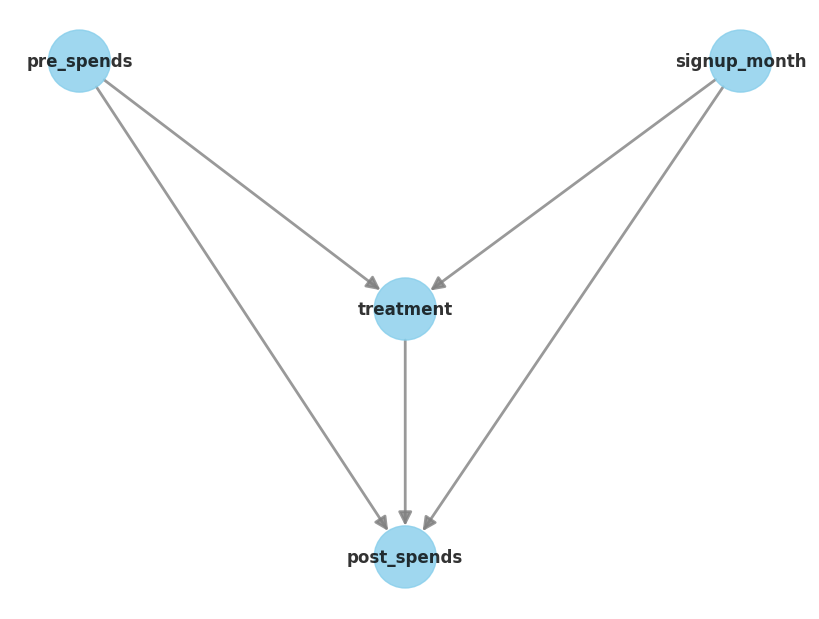

In [16]:
# model.view_model(layout="dot")
model.view_model(layout="dot")

In [17]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                              
────────────(E[post_spends|signup_month,pre_spends])
d[treatment]                                        
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→post_spends then P(post_spends|treatment,signup_month,pre_spends,U) = P(post_spends|treatment,signup_month,pre_spends)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!

### Estimand : 4
Estimand name: general_adjustment
Estimand expression:
     d                                              
────────────(E[post_spends|signup_month,pre_spends])
d[treatment]                                        
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→post_spends then P(post_spends|treatment,signup_month,pre_spends,U) = P(post_spends|treatment,signup_month,pre_spends)



## Estimate causal effect based on the identified estimand

In [21]:
estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.propensity_score_matching",
    target_units="att",
)

In [22]:
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                              
────────────(E[post_spends|signup_month,pre_spends])
d[treatment]                                        
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→post_spends then P(post_spends|treatment,signup_month,pre_spends,U) = P(post_spends|treatment,signup_month,pre_spends)

## Realized estimand
b: post_spends~treatment+signup_month+pre_spends
Target units: att

## Estimate
Mean value: 87.82472281198395



### What Conclusion can we draw from the estimated effect?
This says all confounders affecting both treatment and outcome are included in your model.

It assumes there’s no unobserved variable U that affects both treatment and post_spends.

You’re assuming pre_spends and signup_month are enough to "block" all backdoor paths.

| Group               | Average Post-Spends (Roughly) |
| ------------------- | ----------------------------- |
| Treated (Signed Up) | High (e.g., ₹100)             |
| Matched Controls    | Lower (e.g., ₹12.18 less)     |
| Causal Effect (ATT) | **₹87.82** difference         |


```
Mean value: 87.82
```

<b>"We estimate that signing up for the program causes users to spend ₹87.82 more on average, compared to what they would have spent if they hadn’t signed up, even after accounting for the month and their earlier spending."</b>

## Refutation
💡 “How confident can I be that this causal effect is real and not due to some hidden bias or noise?”

In [23]:
refutation = model.refute_estimate(
    identified_estimand,
    estimate,
    method_name="placebo_treatment_refuter",
    placebo_type="permute",
    num_simulations=20,
)
print(refutation)

Refute: Use a Placebo Treatment
Estimated effect:87.82472281198395
New effect:-0.35714791224345394
p value:0.28540513075337004



The Placebo Test is a method to check the robustness of your causal inference by testing if the effect holds under different conditions or assumptions. It helps to validate whether the observed effect is genuine or if it could be due to confounding factors.

The Test involves creating a "placebo" treatment group that should not have any effect, and then checking if the estimated effect remains significant. If the effect disappears or becomes insignificant in the placebo group, it suggests that the original effect may not be robust.

But in our case the placebo test is not significant, which means the effect we observed is likely genuine and not due to confounding factors.

In our case:
```
placebo_test p_value:0.28540513075337004 
when > 0.05, it means the effect is not significant.
Which means the effect we observed is likely genuine and not due to confounding factors.
```

```
Estimated effect:87.82472281198395
New effect:-0.35714791224345394

Estimated Effect is not affected by the placebo test.
Which States that the effect we observed is likely genuine and not due to confounding factors.
Placebo was not able to find any significant effect.
```

### Conclusion
In this example, we used DoWhy to estimate the causal effect of signing up for a program on user spending. We defined a causal model, identified the estimand, estimated the effect using propensity score matching, and validated our findings through a placebo test.

## Resources:

Kaggle: https://www.kaggle.com/code/adamwurdits/causal-inference-with-dowhy-a-practical-guide<br>
Research Paper: https://arxiv.org/abs/2011.04216<br>
DoWhy Documentation: https://dowhy.readthedocs.io/en/latest/index.html<br>
Youtube: https://www.youtube.com/watch?v=LALfQStONEc&t=1021s<br>
